## call clusters
inputs

        * normalized_expression
        * full_covariates

In [1]:
import pandas as pd
import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
import numpy as np

from residualize import calculate_residual

# not needed for script
import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import spearmanr



In [2]:
# params
max_cluster_size=50
min_cluster_size=2

# what counts as correlated?
# I think this was 0 in tamis
# seems to be looking for sum(is.na(tmp))
# see for example, this cluster: 4,2,"ENSG00000140157.14,ENSG00000273749.4","NIPA2, CYFIP1",100.0,0.086,0.086,,15,Adipose_Subcutaneous
min_corr_cuntoff = .1

# how many pairs have to have abs(pair_corr) above the min_corr_cuntoff value
percent_corr_cutoff=.7

tissue_id = 'Adipose_Subcutaneous'

In [3]:
# load in data
expression_df = pd.read_csv('/home/klawren/oak/pcqtls/data/processed/normalized_expression_tami/Adipose_Subcutaneous.v8.normalized_expression.bed', sep='\t')
expression_df

,#chr,start,end,gene_id,GTEX-1117F,GTEX-111CU,GTEX-111FC,GTEX-111VG,GTEX-111YS,GTEX-1122O,...,GTEX-ZXES,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYFD,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYW4,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPU
0,chr1,29552,29553,ENSG00000227232.5,1.313533,-0.900794,-0.292690,-0.732411,-0.274754,-0.699026,...,-0.347092,0.527368,1.976396,1.776799,-0.324309,-0.894351,-2.256250,0.279229,0.421295,-1.423335
1,chr1,135894,135895,ENSG00000268903.1,-0.397876,0.572460,-1.091816,2.115771,0.103551,0.129569,...,-0.666401,-0.850245,-1.447466,1.038647,-1.303395,-0.347092,0.234711,1.423335,-0.856443,1.002398
2,chr1,137964,137965,ENSG00000269981.1,0.060333,0.995306,-0.844079,2.314897,0.618748,0.704535,...,0.077602,-1.046061,-1.776799,-1.115573,-0.807734,0.488170,0.283710,1.630041,-1.084032,1.226711
3,chr1,173861,173862,ENSG00000241860.6,0.225866,-0.819728,-0.234711,1.068659,0.261361,1.123634,...,2.204469,-1.366375,-1.553621,-1.698852,-0.532324,-0.310720,0.449708,0.239141,-1.313533,0.819728
4,chr1,195410,195411,ENSG00000279457.4,0.292690,-1.002398,0.402542,-0.542275,-1.776799,-0.552281,...,0.297188,1.447466,-1.156632,2.256250,0.582637,-0.195041,0.655684,0.623972,0.572460,-0.894351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24660,chrX,155669943,155669944,ENSG00000185973.10,-1.400004,0.168768,-0.297188,-0.012921,0.195041,-0.981268,...,1.182233,-1.254606,-0.034462,-1.156632,0.342521,-0.021536,0.351670,-2.256250,0.715619,-0.081923
24661,chrX,155767811,155767812,ENSG00000168939.11,-2.204469,-0.043083,-0.749413,-0.900794,1.568183,1.498434,...,1.313533,-0.030153,1.377412,-0.618748,-0.721194,0.017229,-1.798076,0.190653,0.324309,1.165081
24662,chrX,155881292,155881293,ENSG00000124333.15,-0.073283,-0.043083,0.203828,-0.507671,0.704535,-0.650353,...,0.051706,-0.416593,0.946992,0.900794,-1.598348,-0.265820,0.807734,-0.933590,1.148265,1.798076
24663,chrX,155997580,155997581,ENSG00000124334.17,0.940270,-1.148265,-0.407217,1.273758,-1.148265,-0.444948,...,0.738055,-0.221450,-1.148265,-1.148265,-0.645041,1.919012,-1.148265,-0.542275,-0.064649,-0.116550


In [4]:
covariates_df = pd.read_csv('/home/klawren/oak/pcqtls/data/processed/covariates_tami/Adipose_Subcutaneous.v8.covariates.txt', sep='\t', index_col=0).T
covariates_df

ID,PC1,PC2,PC3,PC4,PC5,InferredCov1,InferredCov2,InferredCov3,InferredCov4,InferredCov5,...,InferredCov54,InferredCov55,InferredCov56,InferredCov57,InferredCov58,InferredCov59,InferredCov60,pcr,platform,sex
GTEX-1117F,-0.0867,-0.0132,-0.0062,0.0046,0.0054,0.020909,0.018987,0.034279,-0.004583,0.100213,...,0.028558,-0.108875,-0.135383,-0.062187,0.073324,0.022494,0.009804,1.0,1.0,2.0
GTEX-111CU,0.0107,-0.0026,0.0004,-0.0015,0.0112,-0.020838,-0.024584,0.017718,-0.024737,-0.020060,...,0.019939,0.010496,0.126874,0.168892,-0.108860,0.063715,-0.016651,1.0,1.0,1.0
GTEX-111FC,0.0099,-0.0050,0.0304,0.0076,0.0347,0.043041,-0.014273,0.015329,0.033659,-0.036465,...,0.055394,0.007636,-0.046512,-0.111226,-0.172059,-0.116399,0.210148,1.0,1.0,1.0
GTEX-111VG,0.0144,-0.0081,0.0133,0.0035,0.0018,0.027753,-0.033660,0.007306,-0.087757,0.031649,...,0.094220,-0.057693,-0.073819,0.017391,0.076359,-0.007445,-0.109115,1.0,1.0,1.0
GTEX-111YS,0.0154,-0.0093,0.0107,-0.0038,-0.0083,-0.020914,0.017681,-0.040232,0.010476,0.019253,...,-0.021506,0.089417,0.124951,-0.104352,0.192588,-0.128535,0.009471,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZYVF,0.0118,0.0005,-0.0678,0.0063,0.0326,-0.019215,0.029521,0.048050,-0.088771,-0.017989,...,-0.057573,0.027613,0.217577,0.083199,0.456139,0.011376,0.063828,1.0,1.0,2.0
GTEX-ZYW4,-0.0245,0.2918,0.0227,0.1210,0.0376,0.013738,0.033801,0.037867,0.010357,0.065015,...,0.018522,0.027766,-0.084631,-0.076807,0.035903,-0.021350,0.066904,1.0,1.0,1.0
GTEX-ZYY3,0.0111,-0.0048,-0.0795,-0.0113,0.0100,-0.024992,0.009624,-0.014019,-0.033134,0.054995,...,-0.086990,0.072295,0.012627,-0.193751,-0.103690,0.080859,0.112726,1.0,1.0,2.0
GTEX-ZZ64,0.0137,-0.0048,0.0171,-0.0016,-0.0138,-0.049920,0.004585,-0.007352,0.044326,-0.005257,...,0.098307,-0.034423,-0.094158,0.135274,0.035642,-0.049776,0.055648,1.0,1.0,1.0


In [5]:
# residulize the expression 
residal_exp = calculate_residual(expression_df[covariates_df.index], covariates_df, center=True)
residal_exp = pd.DataFrame(residal_exp, columns=covariates_df.index, index=expression_df['gene_id'])
residal_exp

,GTEX-1117F,GTEX-111CU,GTEX-111FC,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-117YX,GTEX-11DXX,...,GTEX-ZXES,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYFD,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYW4,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPU
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000227232.5,-0.010920,-0.005368,0.019930,0.007208,-0.021872,-0.053110,0.026491,0.017894,0.000386,-0.016673,...,-0.040284,0.072284,0.043416,0.036225,0.047466,-0.035930,-0.035219,-0.003375,0.048670,-0.039268
ENSG00000268903.1,-0.063248,0.030975,0.020710,-0.018623,-0.000728,-0.004470,0.052737,-0.089720,-0.038031,0.048589,...,-0.026074,-0.020204,-0.038054,0.001629,-0.005612,-0.078953,0.002072,0.019109,0.038606,0.083183
ENSG00000269981.1,-0.043514,0.028810,0.019220,-0.023095,0.022431,0.023407,0.038640,-0.151575,-0.066462,0.028538,...,0.001899,-0.029136,-0.045878,-0.050813,0.010719,-0.043997,0.003071,0.036357,0.014159,0.086613
ENSG00000241860.6,-0.002676,-0.043455,-0.016773,0.010214,0.000047,0.068849,0.052208,-0.073213,0.000541,0.016522,...,0.053892,-0.047327,-0.043257,-0.024338,-0.019272,0.031975,0.004621,-0.012527,-0.077464,0.011767
ENSG00000279457.4,0.029146,-0.026367,0.017061,-0.025151,-0.085430,-0.024145,0.012957,-0.105733,-0.020436,0.003320,...,0.010234,0.048648,-0.004212,0.052239,0.018816,-0.031402,-0.000531,0.011266,0.020266,-0.014226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185973.10,0.007483,0.016540,-0.028145,0.019946,0.067194,-0.030645,0.015682,-0.058199,0.001595,0.035278,...,-0.017165,-0.037817,0.005412,0.013024,-0.032811,0.003636,0.017173,-0.024915,-0.033566,0.024520
ENSG00000168939.11,-0.013789,-0.019065,-0.030895,-0.001510,-0.020426,0.020647,-0.021603,-0.040575,0.072211,-0.033797,...,0.002112,-0.023358,0.024843,0.070415,-0.031754,0.001208,0.010806,-0.029612,-0.016043,0.010832
ENSG00000124333.15,0.024797,0.069487,0.007722,-0.007970,0.037216,-0.004854,-0.065182,0.063672,-0.039138,0.078003,...,-0.002309,0.004750,-0.019101,0.009969,-0.064806,-0.068336,0.037712,-0.046365,0.062478,0.022851


In [6]:
def get_corr_diag(df, max_cluster_size):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    corrs = dfcols.transpose().join(dfcols, how='outer')
    for i in range(len(df.columns)):
            gene_id_1 = df.columns[i]
            for j in range(len(df.columns)):
                gene_id_2 = df.columns[j]
                if (i > j) & (i < j + max_cluster_size):
                    result = spearmanr(df[gene_id_1], df[gene_id_2])
                else: 
                    result = (np.NAN, np.NAN)
                corrs[gene_id_1][gene_id_2] = result[0]
                pvalues[gene_id_1][gene_id_2] = result[1]
    return corrs, pvalues

In [7]:
# get total number of pairs included
total_pairs = 0
for i in np.arange(1,23,1):
    chr_gene_ids = expression_df[expression_df['#chr'] == f'chr{i}']['gene_id']
    upper_corner_idxs = np.triu(np.ones(len(chr_gene_ids)), k=1)
    excluded_cluster_size_idxs = np.triu(np.ones(len(chr_gene_ids)), k=max_cluster_size)
    total_pairs += upper_corner_idxs.sum()  - excluded_cluster_size_idxs.sum()

In [8]:
# get expression correlations
# split out by chromosome
chr_id = 21
max_cluster_size = 50

def get_clusters_chr(chr_id, expression_df, residal_exp, total_pairs):
    # genes on this chr
    chr_gene_ids = expression_df[expression_df['#chr'] == f'chr{chr_id}']['gene_id']
    chr_residual_exp = residal_exp.loc[chr_gene_ids]

    # get correlation and pvalues
    chr_corr, chr_pvalue = get_corr_diag(chr_residual_exp.T, max_cluster_size)
    print('calcuated correlations')

    # iterate through and call the cluster
    # list of transcripts that are already in a cluster
    transcript_blacklist = []

    # list of clusters
    cluster_output = []

    for cluster_size in np.arange(max_cluster_size, min_cluster_size-1, -1):
        # total number of pairs we consizer for this cluster size 
        number_pairs = sum(sum(np.triu(np.ones((cluster_size, cluster_size)), k=1)))

        # each possible start along the genome
        for cluster_start_idx in range(0, len(chr_corr)-cluster_size):
            # pull the cluster of this size stating at this index
            
            cluster_candidate = chr_corr.iloc[cluster_start_idx:cluster_start_idx+cluster_size, cluster_start_idx:cluster_start_idx+cluster_size]
            # corr values in upper triangle
            cluster_values = cluster_candidate.values[np.triu_indices(cluster_size, k=1)]
            
            # number of corrs with abs value above cuttoff or p value below cutoff
            if cutoff_type == 'value':
                number_corrs_above_cutoff = sum(sum(abs(cluster_candidate.values)>min_corr_cuntoff))
            elif cutoff_type == 'pvalue':
                # calculate p values below a bonferonni 0.05
                cluster_candidate_pvalues = chr_pvalue.iloc[cluster_start_idx:cluster_start_idx+cluster_size, cluster_start_idx:cluster_start_idx+cluster_size]
                # only take top corner 
                cluster_pvalues = cluster_candidate_pvalues.values[np.triu_indices(cluster_size, k=1)]
                # pvalues values in upper triangle less than 0.05/total number tests
                number_corrs_above_cutoff = sum(cluster_pvalues<(0.05/total_pairs))
            else:
                raise ValueError


            # transcripts
            cluster_transcripts = cluster_candidate.index.values
            # in blacklist?
            in_blacklist = sum(cluster_candidate.index.isin(transcript_blacklist))

            # record cluster if enough pairs have higher enough abs correlation, and not recoreded before
            if (number_corrs_above_cutoff/number_pairs > percent_corr_cutoff) & (in_blacklist==0):
                # this is the data on each cluster we need
                # N_genes,Transcripts,Genes,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue

                cluster_series = pd.Series({'N_genes':cluster_size,
                            'Transcripts':','.join(cluster_transcripts),
                            'Perc_cor':number_corrs_above_cutoff/number_pairs,
                            'Mean_cor':np.mean(cluster_values),
                            'Mean_pos_cor':np.mean(cluster_values[cluster_values>0]),
                            'Mean_neg_cor':np.mean(cluster_values[cluster_values<0]),
                            'Chromosome':chr_id,
                            'Tissue':tissue_id})
                # record cluster
                cluster_output.append(cluster_series)
                # recored transcript ids so they aren't included in another cluster
                [transcript_blacklist.append(id) for id in cluster_transcripts]

    # make one dataframe and write out
    return pd.DataFrame(cluster_output)

In [9]:
chr_gene_ids = expression_df[expression_df['#chr'] == f'chr{21}']['gene_id']
chr_residual_exp = residal_exp.loc[chr_gene_ids]

chr_corr, chr_pvalue = get_corr_diag(chr_residual_exp.T, max_cluster_size)


In [10]:
chr_corr

,ENSG00000277117.4,ENSG00000280071.3,ENSG00000275464.4,ENSG00000280433.1,ENSG00000275993.2,ENSG00000274276.4,ENSG00000275895.6,ENSG00000277067.4,ENSG00000276289.4,ENSG00000281383.1,...,ENSG00000228137.1,ENSG00000239415.1,ENSG00000160294.10,ENSG00000182362.13,ENSG00000160298.17,ENSG00000160299.16,ENSG00000160305.17,ENSG00000160307.9,ENSG00000160310.17,ENSG00000230982.1
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000277117.4,NaN,-0.05935,-0.047329,-0.033102,0.071274,0.036562,-0.125611,0.054756,-0.022281,0.030619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000280071.3,NaN,NaN,0.742411,0.600048,0.006897,-0.005027,0.048527,-0.014156,0.011248,-0.026162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000275464.4,NaN,NaN,NaN,0.570714,0.066024,0.007591,-0.011325,-0.017231,-0.014366,-0.037288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000280433.1,NaN,NaN,NaN,NaN,0.082912,-0.019304,-0.018923,0.000958,0.034224,0.034384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000275993.2,NaN,NaN,NaN,NaN,NaN,-0.049423,-0.004963,-0.021705,0.007274,0.004185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000160299.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.059556,0.020922,0.081995,0.023923
ENSG00000160305.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142247,0.192839,0.050353
ENSG00000160307.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073767,0.011943


In [105]:
get_clusters_chr(22, expression_df, residal_exp, total_pairs)

calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


,N_genes,Transcripts,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue
0,20,"ENSG00000211644.3,ENSG00000211648.2,ENSG000002...",0.747368,0.285379,0.302068,-0.015012,22,Adipose_Subcutaneous
1,8,"ENSG00000240972.1,ENSG00000218537.1,ENSG000002...",0.714286,0.106179,0.486989,-0.274630,22,Adipose_Subcutaneous
2,4,"ENSG00000279278.1,ENSG00000274422.1,ENSG000002...",1.000000,0.360777,0.360777,NaN,22,Adipose_Subcutaneous
3,4,"ENSG00000231466.2,ENSG00000100068.11,ENSG00000...",0.833333,0.303327,0.303327,NaN,22,Adipose_Subcutaneous
4,4,"ENSG00000100139.13,ENSG00000278948.1,ENSG00000...",1.000000,0.300368,0.300368,NaN,22,Adipose_Subcutaneous
...,...,...,...,...,...,...,...,...
62,2,"ENSG00000075240.16,ENSG00000100422.13",1.000000,0.331311,0.331311,NaN,22,Adipose_Subcutaneous
63,2,"ENSG00000260708.1,ENSG00000054611.13",1.000000,-0.296344,NaN,-0.296344,22,Adipose_Subcutaneous
64,2,"ENSG00000213279.2,ENSG00000235111.1",1.000000,0.233245,0.233245,NaN,22,Adipose_Subcutaneous
65,2,"ENSG00000100429.17,ENSG00000188130.13",1.000000,0.348340,0.348340,NaN,22,Adipose_Subcutaneous


In [219]:
expression_df['#chr'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrX'], dtype=object)

In [218]:
np.arange(1,23,1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])

In [220]:
clusters_all_chr = [get_clusters_chr(i, expression_df, residal_exp) for i in np.arange(21,23,1)]

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [222]:
pd.concat(clusters_all_chr)

,N_genes,Transcripts,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue
0,8,"ENSG00000229356.1,ENSG00000160233.7,ENSG000002...",0.714286,0.230047,0.230047,NaN,21,Adipose_Subcutaneous
1,6,"ENSG00000228314.1,ENSG00000230965.1,ENSG000002...",0.866667,0.172686,0.503032,-0.116367,21,Adipose_Subcutaneous
2,6,"ENSG00000243927.5,ENSG00000198743.6,ENSG000002...",0.933333,0.268388,0.268388,NaN,21,Adipose_Subcutaneous
3,6,"ENSG00000223768.1,ENSG00000184274.3,ENSG000002...",0.733333,0.143174,0.155060,-0.023230,21,Adipose_Subcutaneous
4,5,"ENSG00000241945.7,ENSG00000160221.16,ENSG00000...",0.900000,0.194532,0.392644,-0.102634,21,Adipose_Subcutaneous
...,...,...,...,...,...,...,...,...
121,2,"ENSG00000075275.16,ENSG00000234869.1",1.000000,0.387516,0.387516,NaN,22,Adipose_Subcutaneous
122,2,"ENSG00000184164.14,ENSG00000182858.13",1.000000,0.139210,0.139210,NaN,22,Adipose_Subcutaneous
123,2,"ENSG00000100427.15,ENSG00000073146.15",1.000000,0.150215,0.150215,NaN,22,Adipose_Subcutaneous
124,2,"ENSG00000279182.1,ENSG00000205593.11",1.000000,0.188901,0.188901,NaN,22,Adipose_Subcutaneous


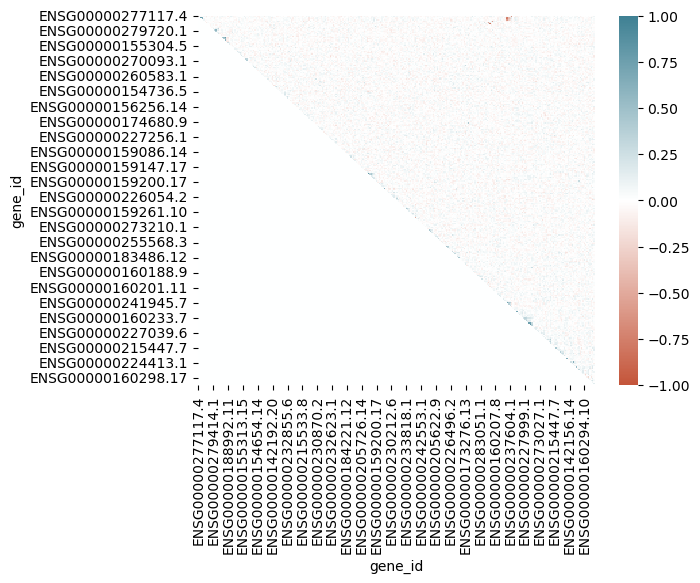

In [203]:
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#c4553aff'), (.5, 'white'), (1, '#3e8093ff')])
sns.heatmap(chr_corr_zeroed, cmap=cmap, vmin=-1, vmax=1)
plt.show()